<a href="https://colab.research.google.com/github/SH0312/KOSA_Pytorch/blob/main/Resnet50-3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train a Custom Resnet34 for Image Classification in fastai and PyTorch
Can I computer tell the diffence between a daisy and a dandelion? The answer is yes


This tutorial shows you how to train a state of the art image classification model with Resnet, in PyTorch, using the fastai library.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Resnet34 image classification model](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Resnet to recognize your custom classes. We use a [public flowers classification dataset](
https://public.roboflow.com/classification/flowers_classification), which is open source and free to use. You can also use this notebook on your own data.

To train our custom classifier we take the following steps:

* Install fastai dependencies
* Expand our training set via augmentations in Roboflow
* Download custom classificatio data from Roboflow
* Download pretrained Resnet Models
* Run frozen Resent training in fastai
* Find a favorable learning rate
* Run unfrozen training
* Inspect our model's evaluation metrics 
* Run Resnet inference on test images
* Export saved Resnet weights for future inference



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)


# Install fastai dependencies

In [12]:
!ls -l

total 18720
-rw-r--r-- 1 root root 16269543 May 25 05:52 3class-v1.zip
drwx------ 6 root root     4096 May 25 05:48 drive
-rw------- 1 root root  2885543 May 25 05:49 s2.jpg
drwxr-xr-x 1 root root     4096 May  6 13:44 sample_data


In [9]:
!cp /content/drive/MyDrive/s2.jpg .

In [ ]:
!unzip ./3class-v1.zip

In [ ]:
!ls -l

total 171756
drwx------ 5 root root      4096 Jan 26 06:33 drive
-rw------- 1 root root  62818019 Jan 26 06:35 Flower-folder.zip
-rw-r--r-- 1 root root      1406 Sep  3 14:50 README.dataset.txt
-rw-r--r-- 1 root root       673 Sep  3 14:50 README.roboflow.txt
drwxr-xr-x 1 root root      4096 Jan 20 17:27 sample_data
drwxr-xr-x 4 root root      4096 Jan 26 06:36 test
drwxr-xr-x 4 root root      4096 Jan 26 06:36 train
-rw-r--r-- 1 root root 113023590 Jan 26 06:34 training_data.zip
drwxr-xr-x 4 root root      4096 Jan 26 06:36 valid


In [ ]:
!pip install fastai

In [15]:
from fastai.vision import *

# Downlaod Custom Classification Data From Roboflow

In [16]:
imagenet_stats


([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [23]:
#build fastai dataset loader
np.random.seed(42)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path('/content/3class-v1')
data = ImageDataBunch.from_folder(path, size=224, num_workers=2).normalize(imagenet_stats)

In [24]:
#double check the data classes
data.classes

['paper', 'rock', 'scissors']

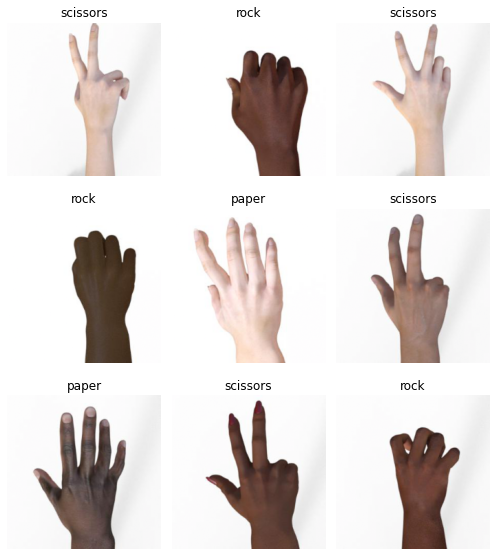

In [26]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(rows=3, figsize=(7, 8))


# Set up fastai Resnet model

In [27]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
#print network layers
learn

# Train Custom Resnet Image Classifier

In [29]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [30]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,time
0,0.135832,0.796468,0.206989,00:48


Better model found at epoch 0 with valid_loss value: 0.7964684963226318.


In [ ]:
#load best model from frozen training
learn.load('best_resnet34')


In [32]:
learn.unfreeze()

In [33]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [35]:
optimal_lr = find_appropriate_lr(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [37]:
optimal_lr

3.019951720402016e-08

In [36]:
learn.fit_one_cycle(50, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


epoch,train_loss,valid_loss,error_rate,time
0,0.010717,0.676976,0.188172,00:56
1,0.017402,0.684886,0.193548,00:56
2,0.014355,0.802982,0.198925,00:56
3,0.012849,0.751325,0.193548,00:56
4,0.010410,0.798787,0.209677,00:56
5,0.009209,0.735822,0.196237,00:55
6,0.009049,0.721275,0.188172,00:56
7,0.010841,0.789677,0.204301,00:56
8,0.008000,0.764661,0.201613,00:56
9,0.006897,0.751614,0.196237,00:56


Better model found at epoch 0 with valid_loss value: 0.6769757270812988.
Epoch 21: early stopping


In [ ]:
learn.load('best_resnet34')


# Evaluate Classifier Performance

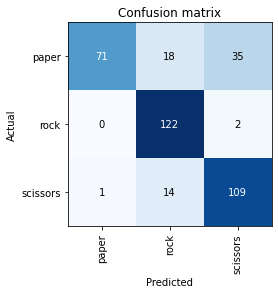

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


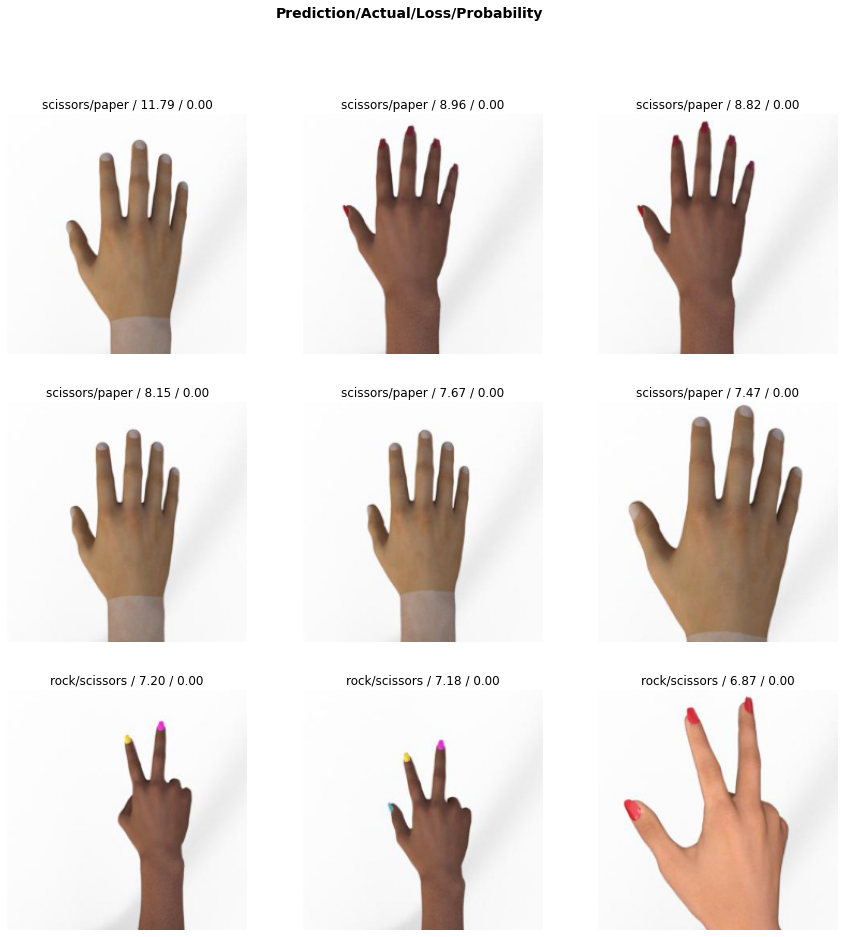

In [40]:
interp.plot_top_losses(9, figsize=(15,15))


In [ ]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/s2.jpg'): #w주먹 가위 보 이미지
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")

# Save custom classification model for future use

In [45]:
#model is automatically saved with the "save_best_model" callback
%ls 3class-v1/models/

best_resnet34.pth  tmp.pth


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
from google.colab import files
files.download('./3class-v1/models/best_resnet34.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>